# af_flag grid_id 값 확인

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

af_path = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_full_combined.csv"
af = pd.read_csv(af_path)

# 고유 grid_id 1줄씩만 추출
af_ids = af["grid_id"].unique()
print(f"af_flag 고유 grid_id 개수: {len(af_ids):,}")

af_flag 고유 grid_id 개수: 4,800


In [2]:
def id2latlon(gid):
    lat_bin = (gid // 3600) - 900
    lon_bin = (gid % 3600) - 1800
    return lat_bin / 10.0, lon_bin / 10.0

# 좌표 배열 생성
lat, lon = zip(*[id2latlon(g) for g in af_ids])

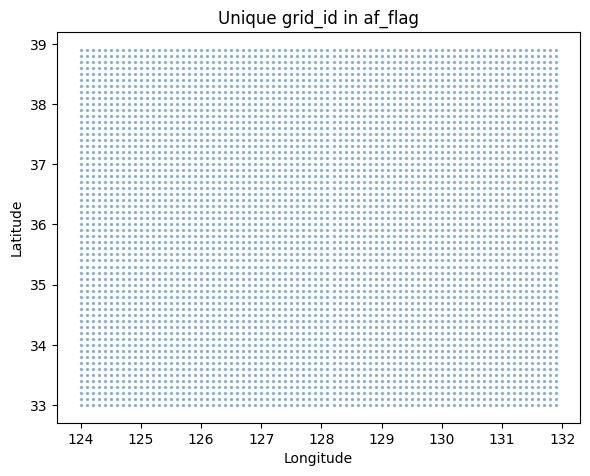

In [3]:
plt.figure(figsize=(6, 6))
plt.scatter(lon, lat, s=2, alpha=0.5, color="steelblue")
plt.title("Unique grid_id in af_flag")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

### af_flag grid_id 제한 방법 체계화 확인
1. af_flag 1값이 포함 grid_id 필터링 or bounding box로 필터링 경우 신뢰성 부족이 있을 수 있음 (세밀한 해안선 반영 어려움)
2. GADM 데이터 활용 필터링 (보류)
3. vworld 데이터 활용 매핑

In [4]:
import requests, pathlib

url  = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_KOR_0.json"
dest = pathlib.Path("shapefiles/gadm41_KOR_0.json")
dest.parent.mkdir(exist_ok=True)

print("다운로드 중…")
dest.write_bytes(requests.get(url).content)
print("저장 완료:", dest.resolve())

다운로드 중…
저장 완료: C:\Users\USER\Desktop\my_git\pof-model-korea\data\shapefiles\gadm41_KOR_0.json


In [5]:
# """
# clip_af_flag_and_weather_to_korea.py
# ─────────────────────────────────────────────────────────────────
# 1. af_flag CSV 로드 → grid_id → (lat, lon) 좌표 복원
# 2. GeoPandas Point 로 변환 후, 대한민국 경계(레벨-0) 폴리곤 안에
#    있는 점만 남김 → af_kor
# 3. ERA5 weather CSV 로드 → 동일 좌표 복원
# 4. 한국 경계 안 weather( w_kor ) × af_kor 를 (grid_id, date) 기준으로
#    inner join → weather_af_df
# 5. 두 결과( af_kor, weather_af_df ) 모두 산점도로 시각화하여
#    “대한민국 영역만 남았는지” 눈으로 검증
# """

# # ── 0. 필수 라이브러리 ───────────────────────────────────
# # pip install geopandas shapely pyproj rtree
# import pandas as pd
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from pathlib import Path

# # ── 1. 경로 정의 ─────────────────────────────────────────
# path_af      = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_full_combined.csv")
# path_weather = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\processed_data\era5_daily_combined_201901_202412.csv")
# path_kor_poly = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\shapefiles\gadm41_KOR_0.json")

# # ── 2. af_flag 로드 & grid_id → 위 경도 복원 ─────────────
# print("… af_flag 로딩")
# af = pd.read_csv(path_af)

# def id2latlon(gid: int) -> tuple[float, float]:
#     """0.1° grid_id → (lat, lon) 실수 좌표로 변환"""
#     lat_bin = (gid // 3600) - 900      # 0.1° 단위 인덱스
#     lon_bin = (gid % 3600) - 1800
#     return lat_bin / 10.0, lon_bin / 10.0

# af[["latitude", "longitude"]] = af["grid_id"].apply(lambda g: pd.Series(id2latlon(g)))

# # GeoDataFrame 변환
# gdf_af = gpd.GeoDataFrame(
#     af,
#     geometry=gpd.points_from_xy(af["longitude"], af["latitude"]),
#     crs="EPSG:4326"                         # 경 위도 좌표계
# )

# # ── 3. 대한민국 폴리곤 로드 ──────────────────────────────
# kor_poly = gpd.read_file(path_kor_poly).to_crs("EPSG:4326")

# # ── 4. 클리핑: 폴리곤 내부 점만 남기기 ─────────────────
# gdf_af_kor = gdf_af.sjoin(kor_poly[["geometry"]],
#                           how="inner",
#                           predicate="within")

# af_kor = (
#     pd.DataFrame(gdf_af_kor)
#       .drop(columns=["geometry", "index_right"])   # 공간컬럼 제거
#       .reset_index(drop=True)
# )
# print(f"af_flag 한국 행 수: {len(af_kor):,}")

# # ── 5. ERA5 weather 로드 & 좌표 복원 ───────────────────
# print("… weather 로딩")
# w = pd.read_csv(path_weather)
# w.rename(columns={'acq_date': 'date'}, inplace=True)  # 날짜 열 이름 통일

# w[["latitude", "longitude"]] = w["grid_id"].apply(lambda g: pd.Series(id2latlon(g)))

# # 동일한 폴리곤으로 weather도 클리핑
# gdf_w = gpd.GeoDataFrame(w,
#                          geometry=gpd.points_from_xy(w["longitude"], w["latitude"]),
#                          crs="EPSG:4326")

# gdf_w_kor = gdf_w.sjoin(kor_poly[["geometry"]],
#                         how="inner",
#                         predicate="within")

# w_kor = (
#     pd.DataFrame(gdf_w_kor)
#       .drop(columns=["geometry", "index_right"])
#       .reset_index(drop=True)
# )
# print(f"weather 한국 행 수: {len(w_kor):,}")

# # ── 6. INNER JOIN (grid_id, date) → weather_af_df ──────
# weather_af_df = pd.merge(w_kor, af_kor,
#                          on=["grid_id", "date"],
#                          how="inner",
#                          suffixes=('', '_af'))

# print(f"weather × af_flag 한국 행 수 : {len(weather_af_df):,}")

# # ── 7. 산점도 시각화로 검증 ─────────────────────────────
# def scatter_unique(df: pd.DataFrame,
#                    title: str,
#                    color: str):
#     pts = df.drop_duplicates("grid_id")
#     plt.scatter(pts["longitude"], pts["latitude"],
#                 s=1, alpha=0.5, color=color)
#     plt.title(title)
#     plt.xlabel("Longitude"); plt.ylabel("Latitude")
#     plt.gca().set_aspect("equal", "box")

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# scatter_unique(af_kor, "af_flag (Korea only)", "red")

# plt.subplot(1, 2, 2)
# scatter_unique(weather_af_df, "Weather × af_flag (Korea only)", "steelblue")

# plt.tight_layout()
# plt.show()

# # ── 8. (선택) 결과 저장 ────────────────────────────────
# out_dir = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\processed_data")
# out_dir.mkdir(exist_ok=True)

# af_kor.to_parquet(out_dir / "af_flag_korea_only.parquet", index=False)
# weather_af_df.to_parquet(out_dir / "weather_af_korea_only.parquet", index=False)

# print("✔️  한국 영역 필터링·시각화 완료")

## vvworld 지번 데이터 활용

빠진 지번 데이터 파악
- 4618283, 강원특별자치도 인제군 북면 한계리 산 일대

In [6]:
import pandas as pd
file_path = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\jibun\korea_grids_with_jibun.parquet"
jibun_df = pd.read_parquet(file_path)
jibun_df.loc[jibun_df['grid_id'] == 4618283, 'jibun'] = "강원특별자치도 인제군 북면 한계리 산 일대"
jibun_df.to_parquet(file_path, index=False)

print("grid_id=4618283의 jibun 값이 변경되었으며, 파일이 덮어씌워져 저장되었습니다.")

grid_id=4618283의 jibun 값이 변경되었으며, 파일이 덮어씌워져 저장되었습니다.


육지 격자 개수: 1,007 / 전체 4,275


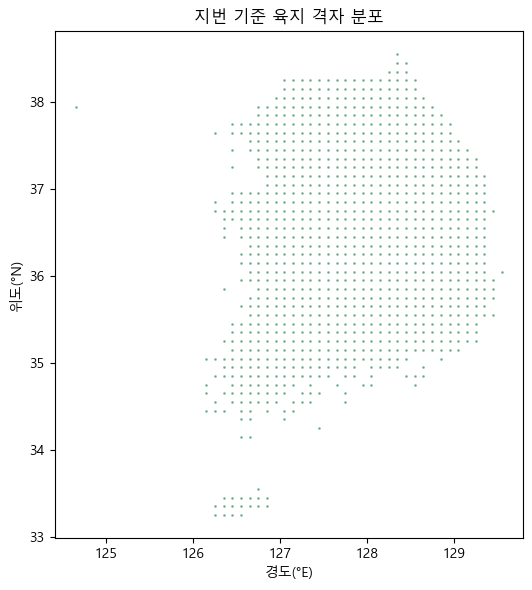

✔️  육지 격자 마스터 저장: C:\Users\USER\Desktop\my_git\pof-model-korea\data\jibun\korea_grids_master_land.parquet


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl

# ─── 한글 폰트 설정 ────────────────────────────────────
# Windows면 기본 'Malgun Gothic', macOS면 'AppleGothic',  
# 없으면 나눔고딕 설치 후 'NanumGothic' 등으로 지정
mpl.rcParams["font.family"] = "Malgun Gothic"   # 또는 AppleGothic / NanumGothic
mpl.rcParams["axes.unicode_minus"] = False      # 마이너스 부호 깨짐 방지

# ─── 1) 지번 마스터 로드 ───────────────────────────────
p_master = Path(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\jibun\korea_grids_with_jibun.parquet"
)
jibun_df = pd.read_parquet(p_master)

# ─── 2) 빈 지번("") 제거 → 육지 격자만 ───────────────
land_df = jibun_df[jibun_df["jibun"].str.strip() != ""].copy()
print(f"육지 격자 개수: {len(land_df):,} / 전체 {len(jibun_df):,}")

# ─── 3) 산점도(한글 레이블) ───────────────────────────
plt.figure(figsize=(6, 6))
plt.scatter(land_df["lon"], land_df["lat"],
            s=1, alpha=0.5, color="seagreen")
plt.title("지번 기준 육지 격자 분포")
plt.xlabel("경도(°E)")
plt.ylabel("위도(°N)")
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

# ─── 4) 저장(선택) ────────────────────────────────────
out_path = Path(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\jibun\korea_grids_master_land.parquet"
)
land_df.to_parquet(out_path, index=False)
print("✔️  육지 격자 마스터 저장:", out_path)

In [8]:
import pandas as pd

path_master = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\jibun\korea_grids_master_land.parquet"

# 1) 파일 메타 & 컬럼 목록
df = pd.read_parquet(path_master, engine="pyarrow")
print("=== info ===")
print(df.info(show_counts=True), "\n")

# 2) 샘플 5행
print("=== head ===")
print(df.head(), "\n")

# 3) 후보 컬럼 값 분포(10개 이하만 출력)
for col in df.columns:
    nunique = df[col].nunique()
    if nunique <= 10:
        print(f"[{col}] unique ({nunique}):", df[col].unique()[:10])


=== info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   grid_id  1007 non-null   int32  
 1   lat      1007 non-null   float64
 2   lon      1007 non-null   float64
 3   jibun    1007 non-null   object 
dtypes: float64(2), int32(1), object(1)
memory usage: 27.7+ KB
None 

=== head ===
   grid_id    lat     lon                       jibun
0  4438262  33.25  126.25  제주특별자치도 서귀포시 대정읍 동일리 943-1
1  4438263  33.25  126.35   제주특별자치도 서귀포시 안덕면 감산리 1212
2  4438264  33.25  126.45       제주특별자치도 서귀포시 대포동 1080
3  4438265  33.25  126.55        제주특별자치도 서귀포시 서홍동 502
4  4441862  33.35  126.25   제주특별자치도 제주시 한림읍 월림리 377-1 



In [9]:
land_grid_id_list = df['grid_id'].unique().tolist()
print(land_grid_id_list)
len(land_grid_id_list)

[4438262, 4438263, 4438264, 4438265, 4441862, 4441863, 4441864, 4441865, 4441866, 4441867, 4441868, 4445463, 4445464, 4445465, 4445466, 4445467, 4445468, 4449067, 4470665, 4470666, 4474274, 4477865, 4477866, 4477870, 4481461, 4481462, 4481463, 4481465, 4481466, 4481468, 4481470, 4481471, 4485062, 4485064, 4485065, 4485066, 4485067, 4485068, 4485069, 4485071, 4485072, 4485073, 4485077, 4488661, 4488663, 4488664, 4488665, 4488666, 4488667, 4488668, 4488669, 4488670, 4488672, 4488673, 4488674, 4488677, 4492261, 4492264, 4492265, 4492266, 4492267, 4492268, 4492269, 4492270, 4492271, 4492273, 4492276, 4492279, 4492280, 4492285, 4495862, 4495863, 4495864, 4495865, 4495866, 4495867, 4495868, 4495869, 4495870, 4495871, 4495872, 4495873, 4495874, 4495875, 4495877, 4495878, 4495880, 4495884, 4495885, 4495886, 4499463, 4499464, 4499465, 4499466, 4499467, 4499468, 4499469, 4499470, 4499471, 4499472, 4499473, 4499474, 4499475, 4499476, 4499477, 4499478, 4499480, 4499481, 4499482, 4499483, 4499486, 

1007

육지 마스터 격자수     : 1,007
af_flag 격자수         : 4,800
겹치는 격자 수        : 1,007
미포함(해역?) 격자 수 : 3,793


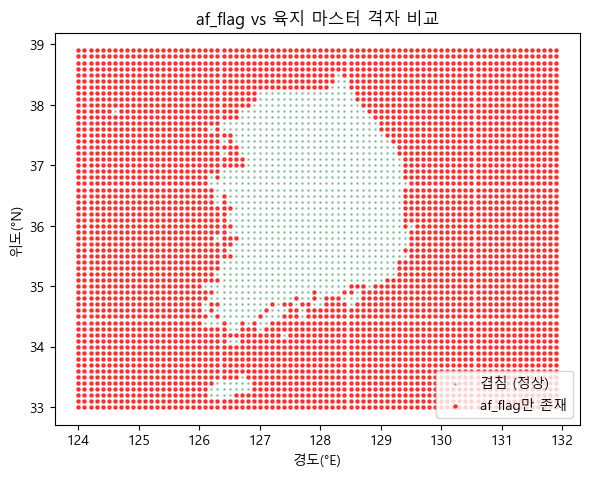

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ── 1) 경로 ───────────────────────────────────────────
p_land = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\jibun\korea_grids_master_land.parquet")   # 방금 만든 육지 마스터
p_af   = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_full_combined.csv")         # af_flag 원본

# ── 2) 로드 & grid_id 집합 추출 ──────────────────────
land_ids = set(pd.read_parquet(p_land, columns=["grid_id"])["grid_id"])
af_df    = pd.read_csv(p_af, usecols=["grid_id", "af_flag", "date"])

af_ids = set(af_df["grid_id"])
print(f"육지 마스터 격자수     : {len(land_ids):,}")
print(f"af_flag 격자수         : {len(af_ids):,}")

# ── 3) 겹침·비겹침 계산 ──────────────────────────────
common_ids   = af_ids & land_ids          # 겹치는 id
missing_ids  = af_ids - land_ids          # af_flag에만 있고 육지엔 없는 id
print(f"겹치는 격자 수        : {len(common_ids):,}")
print(f"미포함(해역?) 격자 수 : {len(missing_ids):,}")

# ── 4) 시각화용 DataFrame 생성 (샘플 좌표 필요) ───────
def id2latlon(g):
    lat_bin = (g // 3600) - 900
    lon_bin = (g % 3600) - 1800
    return lat_bin/10, lon_bin/10

# common
lat_c, lon_c = zip(*[id2latlon(g) for g in list(common_ids)[:100000]])  # 10만개 제한
# missing
if missing_ids:
    lat_m, lon_m = zip(*[id2latlon(g) for g in list(missing_ids)])

# ── 5) 산점도 ────────────────────────────────────────
plt.figure(figsize=(6,6))
plt.scatter(lon_c, lat_c, s=1, alpha=0.4, color="seagreen", label="겹침 (정상)")
if missing_ids:
    plt.scatter(lon_m, lat_m, s=5, alpha=0.7, color="red", label="af_flag만 존재")
plt.title("af_flag vs 육지 마스터 격자 비교")
plt.xlabel("경도(°E)"); plt.ylabel("위도(°N)")
plt.gca().set_aspect("equal","box")
plt.legend(loc="lower right")
plt.tight_layout(); plt.show()

In [11]:
import pandas as pd
from pathlib import Path

# 경로
p_master = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\jibun\korea_grids_master_land.parquet")      # jibun 기반 ‘육지’ 마스터
p_af_in  = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_full_combined.csv")
p_af_out = Path(r"af_flag_land.csv")

# 1) 육지 grid_id 집합
master_ids = set(pd.read_parquet(p_master, columns=["grid_id"])["grid_id"])

# 2) af_flag 로드 → 육지 격자만
af = pd.read_csv(p_af_in)
af_land = af[af["grid_id"].isin(master_ids)].copy()
print(f"af_flag_land 행 수 : {len(af_land):,} / 원본 {len(af):,}")

# 3) 저장
af_land.to_csv(p_af_out, index=False)
af_land.to_parquet(p_af_out.with_suffix(".parquet"), index=False)
print("✔️  af_flag_land 저장:", p_af_out)

af_flag_land 행 수 : 4,318,772 / 원본 20,572,332
✔️  af_flag_land 저장: af_flag_land.csv


In [87]:
af_land['grid_id'].nunique()

1006

# weather_af join

In [1]:
import pandas as pd
from pathlib import Path

# 경로
p_weather = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\processed_data\era5_daily_combined_200001_202412.csv")
p_af_land = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_land.csv")
p_join_out = Path(r"weather_af_land_2001_2024")

# 1) 로드
w  = pd.read_csv(p_weather)
w.rename(columns={'acq_date': 'date'}, inplace=True)   # 날짜 컬럼 통일
af_land = pd.read_csv(p_af_land)

# 2) (grid_id, date) 기준 INNER JOIN
weather_af_land = pd.merge(
    w, af_land,
    on=["grid_id", "date"],
    how="inner",
    suffixes=('', '_af')
)
print("weather_af_land 행 수 :", len(weather_af_land))

# 3) 저장
weather_af_land.to_csv(p_join_out.with_suffix(".csv"), index=False)
weather_af_land.to_parquet(p_join_out.with_suffix(".parquet"), index=False)
print("✔️  결과 저장 :", p_join_out.with_suffix('.*'))

weather_af_land 행 수 : 4243422
✔️  결과 저장 : weather_af_land_2001_2024.*


In [2]:
weather_af_land['grid_id'].nunique()

1006

In [3]:
weather_af_land['date'].unique()

array(['2000-11-02', '2000-11-05', '2000-11-07', ..., '2024-12-17',
       '2024-12-24', '2024-12-31'], dtype=object)

# af_flag == 1 범위확인


         date  grid_id  af_flag
0  2000-11-02  4431040        0
1  2000-11-02  4431041        0
2  2000-11-02  4431042        0
3  2000-11-02  4431043        0
4  2000-11-02  4431044        0


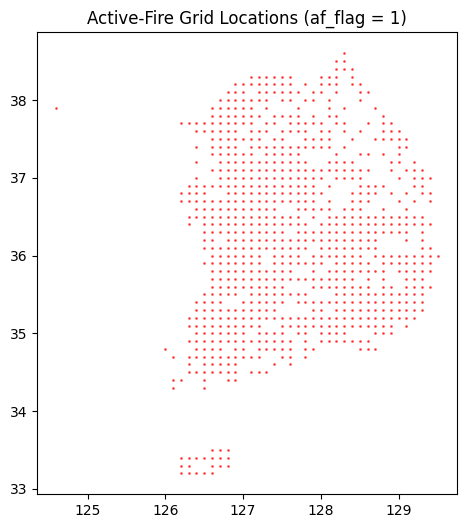

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) af_flag 데이터 로드
af_path = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_full_combined.csv"
af = pd.read_csv(af_path)

# ─── 컬럼 확인 (필요시 이름 조정) ───────────────────────────────
# 예상 컬럼: date, grid_id, latitude, longitude, af_flag
print(af.head())

# 2) af_flag = 1 인 격자만 추출
af_hot = af[af["af_flag"] == 1]

# 3) 중복 좌표 제거 (grid_id별 1점만)
af_hot_pts = af_hot.drop_duplicates("grid_id")

# grid_id → 위 경도 변환
af["lat_bin"] = (af["grid_id"] // 3600) - 900
af["lon_bin"] = (af["grid_id"] % 3600) - 1800
af["latitude"]  = af["lat_bin"] / 10.0
af["longitude"] = af["lon_bin"] / 10.0

# 이후 같은 코드로 산점도
af_hot = af[af["af_flag"] == 1].drop_duplicates("grid_id")
plt.figure(figsize=(8, 6))
plt.scatter(af_hot["longitude"], af_hot["latitude"], s=1, alpha=0.6, color="red")
plt.title("Active-Fire Grid Locations (af_flag = 1)")
plt.gca().set_aspect("equal", "box")
plt.show()

# af_weather 데이터 af_flag grid_id 겹침 탐색

In [14]:
"""
investigate_af_weather_join.py
────────────────────────────────────────────────────────────
목적
1. ERA5 일별 기상 데이터(path1)와 af_flag(path2)의 (grid_id, date) 대응 관계를
   *outer + indicator* 조인으로 확인
2. 조인 결과에서
   - 한국 격자(both) vs. 국외 격자(left_only)의 규모·위치·af_flag 값 파악
3. 필요 시 ERA5(weather) 자체를 한국 영역으로 잘라(클리핑) ‘클린’ 데이터
   생성 후 inner 머지 → 해외 격자 완전 제거
"""

import pandas as pd
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────
# 0) 경로 정의
path_weather = r"C:\Users\USER\Desktop\my_git\pof-model-korea\processed_data\era5_daily_combined_200501_202412.csv"
path_af      = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\af_flag\af_flag_full_combined.csv"

# ──────────────────────────────────────────────────────────
# 1) 데이터 로드
print("… CSV 로드 중")
w = pd.read_csv(path_weather)            # ERA5 weather
a = pd.read_csv(path_af)                 # af_flag (한국 격자만)

# 날짜 컬럼 통일
w.rename(columns={'acq_date': 'date'}, inplace=True)

# ──────────────────────────────────────────────────────────
# 2) outer + indicator 머지 → 키 매칭 현황 확인
print("… Outer merge 수행")
m_all = pd.merge(
    w, a,
    on=['grid_id', 'date'],
    how='outer',
    indicator=True,      # both / left_only / right_only
    suffixes=('', '_af') # 중복 컬럼 구분
)

print("\n=== _merge 분포 ===")
print(m_all['_merge'].value_counts(), "\n")

# ──────────────────────────────────────────────────────────
# 3) grid_id → 위·경도 복원 함수
def id2latlon(gid):
    lat_bin = (gid // 3600) - 900
    lon_bin = (gid % 3600) - 1800
    return lat_bin / 10.0, lon_bin / 10.0

# left_only (weather 전용 격자) 에 좌표 부여
left_only = m_all[m_all['_merge'] == 'left_only'].copy()
left_only[['lat', 'lon']] = left_only['grid_id'].apply(
    lambda g: pd.Series(id2latlon(g))
)

# ──────────────────────────────────────────────────────────
# 4) left_only 지점 시각화 (해외·바다 격자 규모 파악)
plt.figure(figsize=(6, 6))
plt.scatter(left_only['lon'], left_only['lat'], s=1, alpha=0.5, color='orange')
plt.title('left_only grid points  (weather만 존재)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

print(f"left_only 행 수           : {len(left_only):,}")
print("left_only af_flag 값 분포:")
print(left_only['af_flag'].value_counts(dropna=False), "\n")

# ──────────────────────────────────────────────────────────
# 5) ERA5를 한국 Bounding Box로 잘라서 ‘클린’ weather 생성
mask_kor = (
    (w['grid_id'] // 3600 - 900).between(330, 390) &  # lat 33~39
    ((w['grid_id'] % 3600) - 1800).between(1240, 1310)  # lon 124~131
)
w_kor = w[mask_kor].copy()
print(f"Bounding Box 필터 후 weather 행 수 : {len(w_kor):,}")

# ──────────────────────────────────────────────────────────
# 6) af_flag와 inner 머지  → 완전 한국 격자만
clean_merged = pd.merge(w_kor, a, on=['grid_id', 'date'], how='inner')
print(f"clean_merged 행 수              : {len(clean_merged):,}")

# ──────────────────────────────────────────────────────────
# 7) 저장 (필요 시 주석 해제)
# clean_merged.to_csv('weather_af_korea_only.csv', index=False)
# clean_merged.to_parquet('weather_af_korea_only.parquet', index=False)

print("\n프로세스 완료: 해외 격자 규모·af_flag 값 확인 및 한국 영역 클린 데이터 생성")


… CSV 로드 중
… Outer merge 수행

=== _merge 분포 ===
_merge
both          17552084
left_only     17515200
right_only     3020248
Name: count, dtype: int64 



KeyboardInterrupt: 

## weather_af_land grid 체크

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 0) 파일 경로
p_wland = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2000_2024.parquet"

# 1) 로드
df = pd.read_parquet(p_wland, engine="pyarrow")

# 2) grid_id 중복 제거 → 고유 격자 좌표만
pts = df.drop_duplicates("grid_id")[["grid_id", "latitude", "longitude"]]
print("고유 grid_id 개수 :", len(pts))

# 3) 제주·울릉·독도 포함 여부 간단 체크
print("\n⊖ 제주(위도<34) 격자 수  :", (pts["latitude"] < 34.0).sum())
print("⊖ 울릉·독도(경도>130, 위도>37) 격자 수 :", ((pts["longitude"] > 130) & (pts["latitude"] > 37)).sum())

# 4) 산점도 시각화
plt.figure(figsize=(6, 6))
plt.scatter(pts["longitude"], pts["latitude"], s=2, alpha=0.5, color="mediumseagreen")
plt.title("weather_af_land: 격자 분포")
plt.xlabel("경도(°E)"); plt.ylabel("위도(°N)")
plt.gca().set_aspect("equal", "box")
plt.tight_layout(); plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\USER\\Desktop\\my_git\\pof-model-korea\\data\\weather_af_land_2001_2024.parquet'

# landcover check

In [17]:
origin_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_2019_2024.parquet")
origin_df

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag
0,2019-01-01,4431040,33.0,124.0,279.096553,271.864580,2.352574,-7.377966,0.000233,7.743964,0
1,2019-01-01,4431041,33.0,124.2,279.165237,272.005139,2.535549,-7.499906,0.000222,7.916919,0
2,2019-01-01,4431042,33.0,124.3,279.209638,272.096757,2.635533,-7.572204,0.000214,8.017750,0
3,2019-01-01,4431043,33.0,124.4,279.264098,272.209713,2.744013,-7.655831,0.000205,8.132733,0
4,2019-01-01,4431044,33.0,124.5,279.318558,272.322669,2.852493,-7.739457,0.000195,8.248388,0
...,...,...,...,...,...,...,...,...,...,...,...
5442649,2024-12-31,4643514,38.9,131.5,278.336483,270.819575,5.276172,-5.084916,0.001979,7.327643,0
5442650,2024-12-31,4643515,38.9,131.6,278.270558,270.852811,5.294570,-5.221146,0.001938,7.435916,0
5442651,2024-12-31,4643516,38.9,131.7,278.204634,270.886046,5.312969,-5.357377,0.001897,7.545139,0
5442652,2024-12-31,4643517,38.9,131.8,278.143556,270.908833,5.358439,-5.492133,0.002014,7.673095,0


In [24]:
import pandas as pd

file_path = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\landcover\landcover_type1_korea_2001_2023.parquet"
df = pd.read_parquet(file_path, engine="pyarrow")  # 또는 engine="fastparquet"
print(df.info())

print("범주별 데이터 수 :", df['lc_type1'].value_counts())
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441600 entries, 0 to 441599
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       441600 non-null  object 
 1   grid_id    441600 non-null  int32  
 2   latitude   441600 non-null  float64
 3   longitude  441600 non-null  float64
 4   lc_type1   441600 non-null  uint8  
dtypes: float64(2), int32(1), object(1), uint8(1)
memory usage: 12.2+ MB
None
범주별 데이터 수 : lc_type1
0     307398
4      44588
12     38894
8      17749
5      14573
13      8048
1       3117
9       2885
2       2676
10      1094
14       561
11        17
Name: count, dtype: int64
              date  grid_id  latitude  longitude  lc_type1
0       2023-01-01  4643440    38.975    124.025         0
1       2023-01-01  4643440    38.975    124.075         0
2       2023-01-01  4643441    38.975    124.125         0
3       2023-01-01  4643441    38.975    124.175         0
4       2023-01-01  4643442

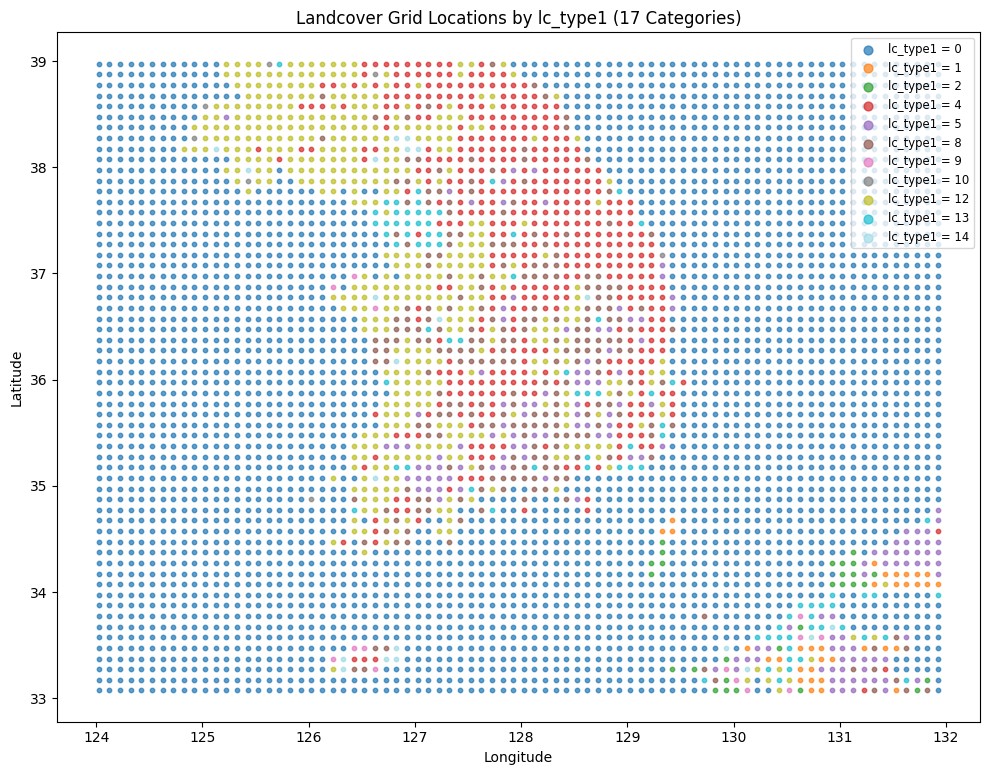

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Parquet 파일 로드
file_path = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\landcover\landcover_type1_korea_2001_2023.parquet"
df = pd.read_parquet(file_path, engine="pyarrow")

# 2) grid_id별 대표 좌표만 남기기
df_unique = df.drop_duplicates(subset="grid_id", keep="first")

lat_col  = "latitude"
lon_col  = "longitude"
type_col = "lc_type1"

# 3) 고유 범주 리스트
types = sorted(df_unique[type_col].unique())
n_types = len(types)

# 4) 범주 수에 맞춘 colormap 생성
#    - tab20 은 20가지 색을 지원하므로, 최대 20개 범주까지 좋습니다.
cmap = plt.get_cmap("tab20", n_types)

plt.figure(figsize=(10,8))

# 5) 각 범주별로 점 찍기
for idx, t in enumerate(types):
    sub = df_unique[df_unique[type_col] == t]
    plt.scatter(
        sub[lon_col],
        sub[lat_col],
        s=10,
        alpha=0.7,
        label=f"lc_type1 = {t}",
        color=cmap(idx)          # idx에 대응하는 색 선택
    )
    
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Landcover Grid Locations by lc_type1 (17 Categories)")
plt.legend(loc="upper right", markerscale=2, fontsize="small")
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd

# 1) origin_df 로드 (Parquet)
origin_path = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_2019_2024.parquet"
origin_df = pd.read_parquet(origin_path, engine="pyarrow")

# 2) date → datetime, year 컬럼 추가
origin_df["date"] = pd.to_datetime(origin_df["date"], format="%Y-%m-%d")
origin_df["year"] = origin_df["date"].dt.year

# 3) landcover Parquet 파일 로드
lc_path = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\landcover\landcover_type1_korea_2001_2023.parquet"
lc = pd.read_parquet(lc_path, engine="pyarrow")

# 4) lc도 date → datetime, year 추가
lc["date"] = pd.to_datetime(lc["date"], format="%Y-%m-%d")
lc["year"] = lc["date"].dt.year

# 5) 필요한 컬럼만 추출
lc_small = lc[["grid_id", "year", "lc_type1"]]

# 6) 병합 (origin_df 기준)
df_merged = origin_df.merge(
    lc_small,
    on=["grid_id", "year"],
    how="left"    # 매칭 없으면 lc_type1이 NaN
)

# 7) 산림 코드로 필터링
#    실제 산림 코드 값으로 리스트를 수정하세요.
forest_codes = [1, 2, 3, 4, 5]
df_forest = df_merged[df_merged["lc_type1"].isin(forest_codes)].copy()

# 8) 결과 확인
print("전체 데이터 크기:", df_merged.shape)
print("산림 영역만:", df_forest.shape)
print(df_forest.head())


전체 데이터 크기: (19068315, 13)
산림 영역만: (2666248, 13)
          date  grid_id  latitude  longitude         t2m        td2m  \
203 2019-01-01  4431090      33.0      129.1  281.089407  275.253772   
227 2019-01-01  4431096      33.0      129.7  280.198603  274.087057   
230 2019-01-01  4431097      33.0      129.8  280.004756  273.808606   
233 2019-01-01  4431098      33.0      129.9  279.824092  273.558639   
236 2019-01-01  4431099      33.0      130.0  279.643428  273.308671   

          10u       10v        tp    wind10m  af_flag  year  lc_type1  
203  7.415652 -7.349003  0.000770  10.440294        0  2019       2.0  
227  4.993842 -4.732898  0.000608   6.880318        0  2019       2.0  
230  4.622113 -4.181205  0.000521   6.232689        0  2019       2.0  
233  4.358295 -3.668461  0.000423   5.696696        0  2019       2.0  
236  4.094477 -3.155717  0.000324   5.169457        0  2019       2.0  


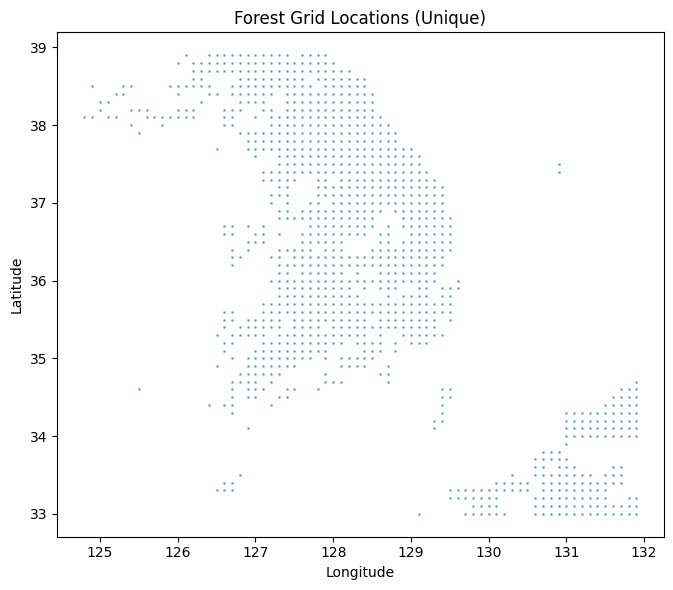

✔️ 병합된 데이터가 저장되었습니다: merged_data.parquet

▶︎ DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19068315 entries, 0 to 19068314
Data columns (total 13 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   grid_id    int64         
 2   latitude   float64       
 3   longitude  float64       
 4   t2m        float64       
 5   td2m       float64       
 6   10u        float64       
 7   10v        float64       
 8   tp         float64       
 9   wind10m    float64       
 10  af_flag    int64         
 11  year       int32         
 12  lc_type1   float64       
dtypes: datetime64[ns](1), float64(9), int32(1), int64(2)
memory usage: 1.8 GB
None

▶︎ 첫 5개 행
        date  grid_id  latitude  longitude         t2m        td2m       10u  \
0 2019-01-01  4431040      33.0      124.0  279.096553  271.864580  2.352574   
1 2019-01-01  4431040      33.0      124.0  279.096553  271.864580  2.352574   
2 2019-01-01  4431040    

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# ─── 1) (이미 메모리에 있다면 생략) df_merged 준비 ───────────────────────
# origin_df = pd.read_parquet("…/weather_af_2019_2024.parquet", engine="pyarrow")
# lc        = pd.read_parquet("…/landcover_type1_korea_2001_2023.parquet", engine="pyarrow")
# origin_df["date"] = pd.to_datetime(origin_df["date"])
# origin_df["year"] = origin_df["date"].dt.year
# lc["date"]        = pd.to_datetime(lc["date"])
# lc["year"]        = lc["date"].dt.year
# lc_small = lc[["grid_id","year","lc_type1","latitude","longitude"]]
# df_merged = origin_df.merge(lc_small, on=["grid_id","year"], how="left")

# ─── 2) 산림 영역만 필터 & 중복 좌표 제거 ───────────────────────────
forest_codes     = [1, 2, 3, 4, 5]  # 실제 산림 코드로 수정
df_forest        = df_merged[df_merged["lc_type1"].isin(forest_codes)]
df_forest_unique = df_forest.drop_duplicates(subset="grid_id", keep="first")

# ─── 3) 간단 산점도 시각화 ───────────────────────────────────────────
plt.figure(figsize=(8, 6))
plt.scatter(
    df_forest_unique["longitude"],
    df_forest_unique["latitude"],
    s=1,
    alpha=0.5
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Forest Grid Locations (Unique)")
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

# ─── 4) 병합 데이터 저장 ─────────────────────────────────────────────
out_path = "merged_data.parquet"
df_merged.to_parquet(out_path, index=False)
print(f"✔️ 병합된 데이터가 저장되었습니다: {out_path}")

# ─── 5) 데이터 구조 및 샘플 확인 ─────────────────────────────────────
print("\n▶︎ DataFrame Info")
print(df_merged.info())
print("\n▶︎ 첫 5개 행")
print(df_merged.head())

In [39]:
df_merged

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,lc_type1
0,2019-01-01,4431040,33.0,124.0,279.096553,271.864580,2.352574,-7.377966,0.000233,7.743964,0,2019,0.0
1,2019-01-01,4431040,33.0,124.0,279.096553,271.864580,2.352574,-7.377966,0.000233,7.743964,0,2019,0.0
2,2019-01-01,4431040,33.0,124.0,279.096553,271.864580,2.352574,-7.377966,0.000233,7.743964,0,2019,0.0
3,2019-01-01,4431040,33.0,124.0,279.096553,271.864580,2.352574,-7.377966,0.000233,7.743964,0,2019,0.0
4,2019-01-01,4431041,33.0,124.2,279.165237,272.005139,2.535549,-7.499906,0.000222,7.916919,0,2019,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19068310,2024-12-31,4643514,38.9,131.5,278.336483,270.819575,5.276172,-5.084916,0.001979,7.327643,0,2024,NaN
19068311,2024-12-31,4643515,38.9,131.6,278.270558,270.852811,5.294570,-5.221146,0.001938,7.435916,0,2024,NaN
19068312,2024-12-31,4643516,38.9,131.7,278.204634,270.886046,5.312969,-5.357377,0.001897,7.545139,0,2024,NaN
19068313,2024-12-31,4643517,38.9,131.8,278.143556,270.908833,5.358439,-5.492133,0.002014,7.673095,0,2024,NaN


# 결측치 확인

In [49]:
print(df_merged['lc_type1'].isna().sum())
print(origin_df.info())
print(df_merged.info())

900767
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5442654 entries, 0 to 5442653
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   grid_id    int64         
 2   latitude   float64       
 3   longitude  float64       
 4   t2m        float64       
 5   td2m       float64       
 6   10u        float64       
 7   10v        float64       
 8   tp         float64       
 9   wind10m    float64       
 10  af_flag    int64         
 11  year       int32         
dtypes: datetime64[ns](1), float64(8), int32(1), int64(2)
memory usage: 477.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19068315 entries, 0 to 19068314
Data columns (total 13 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   grid_id    int64         
 2   latitude   float64       
 3   longitude  float64       
 4   t2m        float64       
 5   td2m       float64     

# 시각화

In [1]:
# (2) 바로 시각화 코드 실행
import folium

center_lat = df_forest["latitude"].mean()
center_lon = df_forest["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=7)
for _, row in df_forest.iterrows():
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=2,
        color="darkgreen",
        fill=True,
        fill_color="darkgreen",
        fill_opacity=0.6
    ).add_to(m)
m

NameError: name 'df_forest' is not defined

# lc_type1 중복 원인 파악

In [50]:
dup = (
    lc_small
    .groupby(["grid_id", "year"])
    .size()
    .reset_index(name="cnt")
    .query("cnt > 1")
)
print("중복 키 예시:")
print(lc_small.merge(dup, on=["grid_id","year"]).head())


중복 키 예시:
   grid_id  year  lc_type1  cnt
0  4643440  2023         0    4
1  4643440  2023         0    4
2  4643441  2023         0    4
3  4643441  2023         0    4
4  4643442  2023         0    4


In [51]:
# (grid_id, year)별로 lc_type1이 몇 종류인지 세기
chk = (
    lc_small
      .groupby(["grid_id", "year"])["lc_type1"]
      .nunique()
      .reset_index(name="n_types")
      .query("n_types > 1")        # 서로 다른 값이 2개 이상인 경우만
)
print("서로 다른 lc_type1이 여러 개인 키 수:", chk.shape[0])

서로 다른 lc_type1이 여러 개인 키 수: 23928


# Land-Cover 병합 & 산림 격자 필터링 정리

## 1. 배경
| 데이터셋 | 기간 | 격자 | 목적 |
|-----------|------|------|------|
| **origin_df** | 2019-01-01 ~ 2024-12-31 (일별) | `grid_id` (0.1 °) | 기상·화재 관측 (t2m, tp, wind10m, af_flag …) |
| **landcover** | 2001-01-01 ~ 2023-01-01 (연 1회) | `grid_id` (0.1 °) | 토지피복 유형 `lc_type1`, 위·경도 |

- 목표: **동적** 기상 + **정적** 토지피복을 합쳐 산림 격자만 추출 → 산불 예측 입력으로 사용.

---

## 2. 문제점 요약
1. **중복 키**  
   - 같은 `(grid_id, year)` 가 land-cover 안에 최대 4행씩 존재.  
   - 4행 모두 `lc_type1` 값이 같을 때가 대부분이지만, **2 만 3928**쌍은 값이 달라 충돌 발생.
2. **연도 불일치**  
   - land-cover 최신 연도가 2023 → 2024년 origin 행은 `lc_type1 = NaN`.
3. **병합 후 행 폭증**  
   - 1 : N 매칭 때문에 540만 → 2천만 행 이상으로 불어나 처리·학습이 비효율.

---

## 3. 해결 전략
| 단계 | 조치 | 효과 |
|------|------|------|
| **1** | origin 데이터에서 2023년까지 필터링 | land-cover와 기간 일치 |
| **2** | land-cover를 `(grid_id, year)` 단위로 **최빈값(mode)** 집계 → 1 행 | 중복 제거·행 폭증 방지 |
| **3** | 2023 스냅숏을 복사해 **2024 연도** 생성 | 2024 기상 데이터에도 토지피복 부여 |
| **4** | 1 : 1 머지 (`left`) | 행 수 유지 (= origin) |
| **5** | 산림 코드 `[1, 2, 3, 4, 5]` 로 필터 | 모델 학습용 숲·관목·조림 격자만 추출 |

---

## 4. 산출물
| 이름 | 내용 |
|------|------|
| **df_merged** | `(grid_id, date)` 별 기상 + `lc_type1` (2001-2024) |
| **df_forest** | 위에서 `lc_type1 ∈ [1-5]` 만 남긴 최종 학습 테이블 |
| **merged_data.parquet** | df_merged 저장 파일 |

---

## 5. 검증 체크리스트
- `origin_trim.shape[0] == df_merged.shape[0]` → 행 폭증 여부
- `df_merged["lc_type1"].isna().mean()` → 결측률(0 이어야 정상)
- `df_forest["grid_id"].nunique()` → 실제 산림 격자 수 확인


## forest 필터링 후 저장

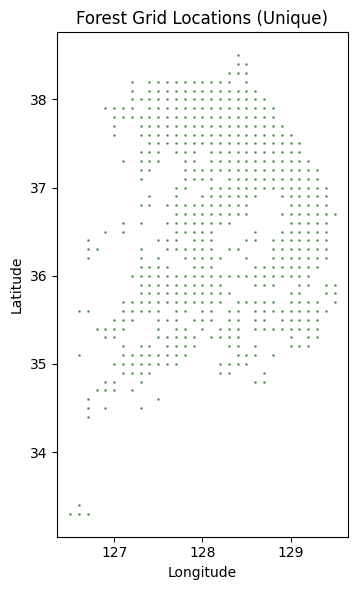

origin rows   : 4243422
merged rows   : 4243422
forest rows   : 2095847
NaN lc_type1  : 6037


In [5]:
"""
merge_forest_dataset.py
────────────────────────────────────────────────────────────
1. 일별 기상·화재 관측(origin_df, 2019-2024) + 연별 토지피복(landcover, 2001-2023)
2. landcover 중복 → (grid_id, year) 별 lc_type1 최빈값(mode)
3. 2023 스냅숏을 복사해 2024 연도로 보강
4. origin 좌표 한 세트만 남기고 머지
5. 산림 lc_type1 (1~5) 격자만 추출
6. 결과 저장 + 간단 산점도
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ──────────────────────────────────────────────────────────
# 1) 데이터 로드 ────────────────────────────────────────
origin_path = Path(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data"
    r"\weather_af_land_2000_2024.parquet"
)
land_path = Path(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\landcover"
    r"\landcover_type1_korea_2001_2023.parquet"
)

origin = pd.read_parquet(origin_path, engine="pyarrow")   # ← weather_af_land_df
land   = pd.read_parquet(land_path,   engine="pyarrow")


# ──────────────────────────────────────────────────────────
# 2) 날짜 → datetime, year 컬럼
origin["date"] = pd.to_datetime(origin["date"])
origin["year"] = origin["date"].dt.year

land["date"] = pd.to_datetime(land["date"])
land["year"] = land["date"].dt.year

# ──────────────────────────────────────────────────────────
# 3) landcover 중복 해소: (grid_id, year)별 lc_type1 최빈값(mode)
def mode(s):
    return s.value_counts().idxmax()

land_unique = (
    land[["grid_id", "year", "lc_type1", "latitude", "longitude"]]
      .groupby(["grid_id", "year"])
      .agg({
          "lc_type1": mode,       # lc_type1 최빈값
          "latitude":  "first",   # 좌표 임의 1개 (필요 시 mean 도 가능)
          "longitude": "first"
      })
      .reset_index()
)

# ──────────────────────────────────────────────────────────
# 4) 2023 스냅숏을 복사 → 2024 연도 보강
land_2023 = land_unique[land_unique["year"] == 2023]
land_2024 = land_2023.copy()
land_2024["year"] = 2024

land_full = pd.concat([land_unique, land_2024], ignore_index=True)

# ──────────────────────────────────────────────────────────
# 5) merge (origin 좌표를 보존)
df_merged = origin.merge(
    land_full,
    on=["grid_id", "year"],
    how="left",
    suffixes=("", "_lc")      # origin: latitude, land: latitude_lc
)

# landcover 좌표는 더 이상 필요 없으므로 삭제
df_merged = df_merged.drop(columns=["latitude_lc", "longitude_lc"])

# ──────────────────────────────────────────────────────────
# 6) 산림 격자 필터 (lc_type1 ∈ 1~5)
forest_codes = [1, 2, 3, 4, 5]
df_forest = df_merged[df_merged["lc_type1"].isin(forest_codes)].copy()

# ──────────────────────────────────────────────────────────
# 7) 저장
out_dir = Path(".")
out_dir.mkdir(exist_ok=True)

df_merged.to_parquet(out_dir / "af_landcover_data.parquet",  index=False)
df_forest.to_parquet(out_dir / "weather_af_land_forestfiltered.parquet", index=False)

# ──────────────────────────────────────────────────────────
# 8) 간단 산점도 (산림 격자 위치, 중복 좌표 제거)
unique_pts = df_forest.drop_duplicates("grid_id")

plt.figure(figsize=(8, 6))
plt.scatter(unique_pts["longitude"], unique_pts["latitude"],
            s=1, alpha=0.5, color="darkgreen")
plt.title("Forest Grid Locations (Unique)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────────────────
print("origin rows   :", origin.shape[0])
print("merged rows   :", df_merged.shape[0])        # origin 과 같아야 함
print("forest rows   :", df_forest.shape[0])
print("NaN lc_type1  :", df_merged['lc_type1'].isna().sum())

In [6]:
df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered.parquet")
df

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,lc_type1
0,2001-01-19,4571473,36.9,127.4,274.496903,271.659738,-1.062111,-0.402640,0.005851,1.135869,0,2001,4.0
1,2001-01-19,4571492,36.9,129.3,274.890503,272.616802,0.260648,0.476542,0.006618,0.543166,0,2001,4.0
2,2001-01-19,4571485,36.9,128.6,273.363133,271.073355,-0.765622,0.002116,0.005662,0.765625,0,2001,4.0
3,2001-01-19,4571484,36.9,128.5,273.466056,271.123505,-0.806055,0.018435,0.005872,0.806266,0,2001,4.0
4,2001-01-19,4571483,36.9,128.4,273.440177,271.103791,-0.792894,0.017399,0.006018,0.793085,0,2001,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095842,2024-12-31,4503081,35.0,128.2,275.604777,265.757645,1.162736,-1.858842,0.000000,2.192544,0,2024,5.0
2095843,2024-12-31,4503076,35.0,127.7,274.335392,264.998953,1.717855,-2.163497,0.000000,2.762561,0,2024,4.0
2095844,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000,2.934245,0,2024,4.0
2095845,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000,3.237600,0,2024,5.0


In [ ]:
dup = (
    lc_small
    .groupby(["grid_id", "year"])
    .size()
    .reset_index(name="cnt")
    .query("cnt > 1")
)
print("중복 키 예시:")
print(lc_small.merge(dup, on=["grid_id","year"]).head())


중복 키 예시:
   grid_id  year  lc_type1  cnt
0  4643440  2023         0    4
1  4643440  2023         0    4
2  4643441  2023         0    4
3  4643441  2023         0    4
4  4643442  2023         0    4


# merge_forest_dataset.py ― 로직 흐름 설명

이 스크립트는 **일별 기상·화재 관측 데이터**(2019-2024)와 **연별 토지피복 데이터**(2001-2023)를  
`grid_id` + `year` 기준으로 결합하여 **산림 격자(토지피복 코드 1‒5)**만 추출·저장합니다.

---

## 1. 데이터 로드
| 변수 | 내용 |
|------|------|
| `origin` | `weather_af_2019_2024.parquet` ― 2019-2024 일별 기상·화재 |
| `land`   | `landcover_type1_korea_2001_2023.parquet` ― 2001-2023 연별 토지피복 |

---

## 2. 날짜 처리 → `year` 컬럼 생성
```python
origin["date"] = pd.to_datetime(origin["date"])
origin["year"] = origin["date"].dt.year

land["date"] = pd.to_datetime(land["date"])
land["year"] = land["date"].dt.year
